# ADA Project

----

#### Subject: 
finding what influence the number of protests among: area of the country, population density, net migration, infant mortality, deathrate, income group, climate, etc.  

#### Objective: 
finding what to change in a country to decrease the number of protests (assuming that a less number of protests means that the inhabitants are happier)

----
#### Summary:
First, we will get all the data we need. Second we will find a way to display data on a world map to visualize the number of protests around the world. Then, we will try to find the impact of many variables on this number of protests.


In [132]:
from google.cloud import bigquery
from google.cloud import language
import pandas as pd
import os
import json
import folium
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
DATA_PATH = "data/"
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = 'C:\\Users\\antho\\Downloads\\ADAproj-02b470a29ee4.json'#
# get json by following (Setting up authentication)
# https://cloud.google.com/bigquery/docs/reference/libraries

In [94]:
bigquery_client = bigquery.Client()

# Getting the main tables:

- event codes table
- indication of richness per inhabitant per country
- Protests for leadership change
- Protests for rights
- country codes table
- country codes conversion iso2 to iso3
- statistics on countries

### Event codes:

In [95]:
event_codes = pd.read_csv(DATA_PATH + "eventcodes.csv", encoding = "ISO-8859-1")

In [96]:
event_codes[event_codes['EVENTDESCRIPTION'].str.contains('leadership change')]

,CAMEOEVENTCODE,EVENTDESCRIPTION
223,1411,Demonstrate for leadership change
228,1421,Conduct hunger strike for leadership change
233,1431,Conduct strike or boycott for leadership change
238,1441,Obstruct passage to demand leadership change
243,1451,Engage in violent protest for leadership change


In [97]:
event_codes[event_codes['EVENTDESCRIPTION'].str.contains('for rights')]

,CAMEOEVENTCODE,EVENTDESCRIPTION
27,243,Appeal for rights
109,833,Accede to demands for rights
183,1233,Reject request for rights
225,1413,Demonstrate for rights
230,1423,Conduct hunger strike for rights
235,1433,Conduct strike or boycott for rights
245,1453,Engage in violent protest for rights


### Indication of richness per inhabitant per country per year:

In [98]:
country_by_income_per_year = pd.read_csv(DATA_PATH + "country_by_income.csv", encoding = "ISO-8859-1")

In [99]:
country_by_income_per_year.head()

,Country Code,Economy,Income Group,Year,Latitude,Longitude
0,ZWE,Zimbabwe,Lower middle income (LM),1987,"-19,098","30,047"
1,ZMB,Zambia,Low income (L),1987,"-15,13","25,268"
2,YEM,"Yemen, Rep.",Lower middle income (LM),1987,"15,569","47,793"
3,PSE,West Bank and Gaza,NaN,1987,"32,097","35,26"
4,VIR,Virgin Islands (U.S.),High income (H),1987,"17,74","-64,8"


In [100]:
country_by_income_per_year=country_by_income_per_year.dropna()
#here we only get an indicator of the income, we need to transform it to process it
#we choose to transform Low income (L) to 1, (LM) to 3, (UM) to 4, (H) to 6
country_by_income_per_year=country_by_income_per_year.replace('Low income (L)', '1')
country_by_income_per_year=country_by_income_per_year.replace('Lower middle income (LM)', '3')
country_by_income_per_year=country_by_income_per_year.replace('Upper middle income (UM)', '4')
country_by_income_per_year=country_by_income_per_year.replace('High income (H)', '6')
country_by_income_per_year['Income Group']=country_by_income_per_year['Income Group'].astype(int)
country_by_income_per_year['Income Group'].unique()

array([3, 1, 6, 4], dtype=int64)

### Getting protests events (for rights, for leadership change, etc):

In [101]:
query_protests = bigquery_client.query(
    """SELECT ActionGeo_CountryCode,AvgTone FROM `gdelt-bq.gdeltv2.events` 
    WHERE EventCode LIKE '14%' AND EventCode NOT LIKE '140' AND EventCode NOT LIKE '141'""")
protests_df = query_protests.result().to_dataframe()
protests_df=protests_df.dropna()

In [102]:
#Displaying number of protests available in the data
protests_df.count()

ActionGeo_CountryCode    700120
AvgTone                  700120
dtype: int64

### Protests for rigths:

In [103]:
#Getting number of protests related to rights 
query_rights_protests = bigquery_client.query(
    """SELECT COUNT(EventCode) as nb_protests FROM `gdelt-bq.gdeltv2.events` 
    WHERE EventCode LIKE '1413' OR EventCode LIKE '1423' 
    OR EventCode LIKE '1433' OR EventCode LIKE '1443' OR EventCode LIKE '1453'""")
rights_protests_df = query_rights_protests.result().to_dataframe()

In [104]:
rights_protests_df.head()

,nb_protests
0,630


### Country codes conversion iso2 to iso3 and iso3 to name:

In [107]:
#Getting conversion between iso2 and iso3 code for countries
country_codes_iso2_to_iso3 = pd.read_csv(DATA_PATH + "country_codes_iso2_to_iso3.csv", encoding = "ISO-8859-1")
country_codes_iso2_to_iso3.head()

,ISO,ISO3
0,AD,AND
1,AE,ARE
2,AF,AFG
3,AG,ATG
4,AI,AIA


In [108]:
#Getting conversion between country code and country name
country_codes_to_name = pd.read_csv(DATA_PATH + "country_code_to_name.csv", encoding = "ISO-8859-1")
country_codes_to_name.head()

,Country Code,Country Name
0,AND,Andorra
1,ARE,United Arab Emirates
2,AFG,Afghanistan
3,ATG,Antigua and Barbuda
4,AIA,Anguilla


### Getting statistics on countries:

In [109]:
#Getting data about statistics on all the countries
countries_stats = pd.read_csv(DATA_PATH + "countries_stats.csv", encoding = "ISO-8859-1")
countries_stats.head()

,Country Name,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),Phones (per 1000),Arable (%),Crops (%),Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,3.2,12.13,0.22,87.65,1.0,46.60,20.34,0.380,0.240,0.380
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,71.2,21.09,4.42,74.49,3.0,15.11,5.22,0.232,0.188,0.579
2,Algeria,NORTHERN AFRICA,32930091,2381740,13.8,0.04,-0.39,31.00,6000.0,70.0,78.1,3.22,0.25,96.53,1.0,17.14,4.61,0.101,0.600,0.298
3,American Samoa,OCEANIA,57794,199,290.4,58.29,-20.71,9.27,8000.0,97.0,259.5,10.00,15.00,75.00,2.0,22.46,3.27,NaN,NaN,NaN
4,Andorra,WESTERN EUROPE,71201,468,152.1,0.00,6.60,4.05,19000.0,100.0,497.2,2.22,0.00,97.78,3.0,8.71,6.25,NaN,NaN,NaN


### Visualizing average income per country on a world map

In [110]:
state_geo_path = DATA_PATH + r'world-countries.json'
geo_json_data = json.load(open(state_geo_path))

In [134]:
world_map = folium.Map([20,0], tiles='cartodbpositron', zoom_start=1)
folium.GeoJson(geo_json_data).add_to(world_map)

world_map.save('world_map.html')
display(HTML("<h1><a href='world_map.html' target='_blank'>world_map (Ctrl+Click)</a></h1>"))

world_map

In [112]:
#Displaying the income in 2017
country_by_income_2017 = country_by_income_per_year[country_by_income_per_year['Year'] == 2017]
country_by_income_2017.head()

,Country Code,Economy,Income Group,Year,Latitude,Longitude
6540,ZWE,Zimbabwe,1,2017,"-19,098","30,047"
6541,ZMB,Zambia,3,2017,"-15,13","25,268"
6542,YEM,"Yemen, Rep.",1,2017,"15,569","47,793"
6543,PSE,West Bank and Gaza,3,2017,"32,097","35,26"
6544,VIR,Virgin Islands (U.S.),6,2017,"17,74","-64,8"


In [135]:
results_map_income = folium.Map([20,0], tiles='cartodbpositron', zoom_start=2)
results_map_income.choropleth(geo_data=geo_json_data, data=country_by_income_2017,
             columns=['Country Code', 'Income Group' ],
             key_on='feature.id',
             fill_color='BuGn', fill_opacity=0.9, line_opacity=0.2,
             legend_name='Income per country in 2017 (Low = 1, High = 6)',
                       reset=True)

results_map_income.save('results_map_income.html')
display(HTML("<h1><a href='results_map_income.html' target='_blank'>results_map_income (Ctrl+Click)</a></h1>"))

results_map_income

### Displaying percentage of protests on a world map

In [114]:
#displaying number of protests available
protests_df.count()

ActionGeo_CountryCode    700120
AvgTone                  700120
dtype: int64

In [115]:
#join the protests dataframe to get the iso3 convention for each country
protests_df=pd.merge(protests_df, country_codes_iso2_to_iso3, how='right', left_on=['ActionGeo_CountryCode'], right_on=['ISO'])

Text(0,0.5,'Countries number')

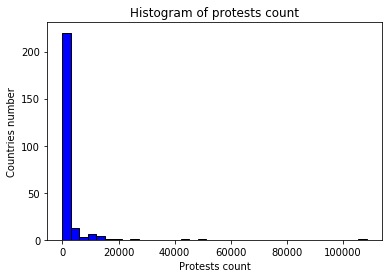

In [137]:
#changing the column name to keep the same naming convention in each dataframe
protests_df=protests_df.rename(index=str, columns={"ISO3": "Country Code"})

#counting the number of protests we have in each country
number_of_protests_per_country = protests_df.groupby(['Country Code']).size().reset_index(name='protests count')

#Getting the distribution of protests count
plt.hist(number_of_protests_per_country['protests count'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of protests count')
plt.xlabel('Protests count')
plt.ylabel('Countries number')


Text(0,0.5,'Countries number')

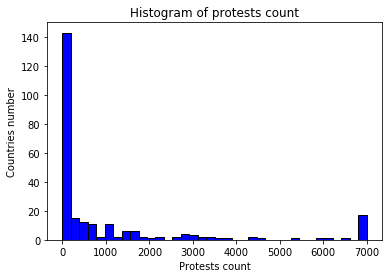

In [138]:
#adding a threshold to avoid that countries with a very high number hids the nuance on other countries
#for instance, if country A has 1 protests, country B has 5000 protests and country C has 100 000 protests,
#we won't see any difference between country A and B. A threshold resolves this issue
threshold = 7000
number_of_protests_per_country[number_of_protests_per_country['protests count'] > threshold] = threshold

#Getting the new distribution of protests count after the threshold
plt.hist(number_of_protests_per_country['protests count'], color = 'blue', edgecolor = 'black',
         bins = int(180/5))

# Add labels
plt.title('Histogram of protests count')
plt.xlabel('Protests count')
plt.ylabel('Countries number')

In [139]:
results_map_protests = folium.Map([20,0], tiles='cartodbpositron', zoom_start=2)
results_map_protests.choropleth(geo_data=geo_json_data, data=number_of_protests_per_country,
             columns=['Country Code', 'protests count'],
             key_on='feature.id',
             fill_color='YlGnBu', fill_opacity=0.9, line_opacity=0.2,
             legend_name='Number of protests from 2005 (threshold at: {})'.format(threshold),
                       reset=True)

results_map_protests.save('results_map_protests.html')
display(HTML("<h1><a href='results_map_protests.html' target='_blank'>results_map_protests (Ctrl+Click)</a></h1>"))

results_map_protests

### Is there any correlation between number of protests and other statistics?

In [119]:
#Getting number of protests per country without any threshold
number_of_protests_per_country = protests_df.groupby(['Country Code']).size().reset_index(name='protests count')

In [120]:
#Extracting the two column we are interesting in
country_by_income_2017_filtered=country_by_income_2017[['Country Code','Income Group']]

In [121]:
#joining tables to get the country, the income group and the protests count in the same table
income_group_and_protests_count=pd.merge(country_by_income_2017_filtered, number_of_protests_per_country, how='right', on=['Country Code'])
income_group_and_protests_count.head()

,Country Code,Income Group,protests count
0,ZWE,1.0,1
1,ZMB,3.0,1
2,YEM,1.0,1
3,PSE,3.0,98
4,VIR,6.0,64


In [122]:
countries_stats_with_code=pd.merge(countries_stats, country_codes_to_name, how='left', on='Country Name')
countries_stats_with_code=countries_stats_with_code.dropna()

In [129]:
#Getting a dataframe with all the statistics by country!
countries_all_stats=pd.merge(countries_stats_with_code, income_group_and_protests_count, how='left', on='Country Code')
countries_all_stats=countries_all_stats.dropna()
#Using countries that have more than 1 protest for the linear regression
countries_all_stats=countries_all_stats[countries_all_stats['protests count'] > 1]
countries_all_stats.head()

,Country Name,Region,Population,Area (sq. mi.),Pop. Density (per sq. mi.),Coastline (coast/area ratio),Net migration,Infant mortality (per 1000 births),GDP ($ per capita),Literacy (%),...,Other (%),Climate,Birthrate,Deathrate,Agriculture,Industry,Service,Country Code,Income Group,protests count
0,Afghanistan,ASIA (EX. NEAR EAST),31056997,647500,48.0,0.00,23.06,163.07,700.0,36.0,...,87.65,1.0,46.60,20.34,0.380,0.240,0.380,AFG,1.0,3537
1,Albania,EASTERN EUROPE,3581655,28748,124.6,1.26,-4.93,21.52,4500.0,86.5,...,74.49,3.0,15.11,5.22,0.232,0.188,0.579,ALB,4.0,3029
4,Argentina,LATIN AMER. & CARIB,39921833,2766890,14.4,0.18,0.61,15.18,11200.0,97.1,...,87.21,3.0,16.73,7.55,0.095,0.358,0.547,ARG,6.0,3160
5,Armenia,C.W. OF IND. STATES,2976372,29800,99.9,0.00,-6.47,23.28,3500.0,98.6,...,80.15,4.0,12.07,8.23,0.239,0.343,0.418,ARM,4.0,3084
7,Australia,OCEANIA,20264082,7686850,2.6,0.34,3.98,4.69,29000.0,100.0,...,93.41,1.0,12.14,7.51,0.038,0.262,0.700,AUS,6.0,1458


In [130]:
#Using linear regression to find impact of each variable on the protests count
from sklearn.linear_model import LinearRegression, LogisticRegression
feature_cols = ['Population', 'Area (sq. mi.)', 'Pop. Density (per sq. mi.)', 'Net migration', 
                'Infant mortality (per 1000 births)', 'GDP ($ per capita)', 'Deathrate', 
                'Income Group', 'Phones (per 1000)', 'Climate', 'Birthrate',
                'Coastline (coast/area ratio)', 'Literacy (%)', 'Arable (%)', 'Crops (%)',
                'Arable (%)', 'Crops (%)']
X = countries_all_stats[feature_cols]
y = countries_all_stats['protests count']
logistic = LinearRegression()  # create the model
logistic.fit(X, y)  # train it
for f in range(len(feature_cols)):
    print("{0} * {1} + ".format(logistic.coef_[f], feature_cols[f]))
print(logistic.intercept_)

5.8194077449590885e-06 * Population + 
0.00247210414136508 * Area (sq. mi.) + 
-0.6642569343161769 * Pop. Density (per sq. mi.) + 
-57.50818060554359 * Net migration + 
28.959359006974942 * Infant mortality (per 1000 births) + 
0.19012129999006225 * GDP ($ per capita) + 
-468.456537953557 * Deathrate + 
-1354.602334644964 * Income Group + 
27.995173096062643 * Phones (per 1000) + 
1563.4655861485332 * Climate + 
311.3959724069827 * Birthrate + 
-45.73721226793009 * Coastline (coast/area ratio) + 
-1.4099226305676507 * Literacy (%) + 
53.02429470039555 * Arable (%) + 
-6.771373315763982 * Crops (%) + 
53.02429470038877 * Arable (%) + 
-6.771373315763086 * Crops (%) + 
-8018.251349065947


Meaning of climate:

1- Dry tropical

2- Wet tropical

3- Temperate humid subtropical and temperate continental

4- Dry hot summers and wet winters